In [85]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='../datas/Cora', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


d:\Anaconda\envs\torch\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
d:\Anaconda\envs\torch\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [86]:
# 可视化节点表征分布的方法
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# MLP

In [87]:
import torch
import torch.nn.functional as F
from torch.nn import Linear

class MLP(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin_1 = Linear(in_c, hid_c)
        self.lin_2 = Linear(hid_c, out_c)

    def forward(self, x):
        x = self.lin_1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin_2(x)
        return x

model = MLP(in_c=dataset.num_features, hid_c=32, out_c=dataset.num_classes)
print(model)

MLP(
  (lin_1): Linear(in_features=1433, out_features=32, bias=True)
  (lin_2): Linear(in_features=32, out_features=7, bias=True)
)


In [88]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(0,200):
    optimizer.zero_grad()
    out = model(data.x)
    l = loss(out[data.train_mask], data.y[data.train_mask])
    l.backward()
    optimizer.step()
    print("Epoch:{:03d}, loss:{:.4f}".format(epoch+1, l.item()))




Epoch:001, loss:1.9477
Epoch:002, loss:1.9418
Epoch:003, loss:1.9354
Epoch:004, loss:1.9297
Epoch:005, loss:1.9220
Epoch:006, loss:1.9134
Epoch:007, loss:1.9036
Epoch:008, loss:1.8885
Epoch:009, loss:1.8762
Epoch:010, loss:1.8659
Epoch:011, loss:1.8399
Epoch:012, loss:1.8262
Epoch:013, loss:1.8097
Epoch:014, loss:1.7938
Epoch:015, loss:1.7625
Epoch:016, loss:1.7385
Epoch:017, loss:1.7047
Epoch:018, loss:1.6954
Epoch:019, loss:1.6551
Epoch:020, loss:1.6205
Epoch:021, loss:1.5999
Epoch:022, loss:1.5783
Epoch:023, loss:1.5252
Epoch:024, loss:1.4918
Epoch:025, loss:1.4525
Epoch:026, loss:1.4109
Epoch:027, loss:1.3808
Epoch:028, loss:1.3669
Epoch:029, loss:1.3100
Epoch:030, loss:1.2754
Epoch:031, loss:1.2075
Epoch:032, loss:1.1800
Epoch:033, loss:1.1401
Epoch:034, loss:1.1019
Epoch:035, loss:1.1085
Epoch:036, loss:1.0502
Epoch:037, loss:1.0352
Epoch:038, loss:0.9887
Epoch:039, loss:0.9480
Epoch:040, loss:0.8635
Epoch:041, loss:0.8248
Epoch:042, loss:0.7683
Epoch:043, loss:0.7914
Epoch:044, 

In [89]:
model.eval()
out = model(data.x)
preds = out.argmax(dim=1)
hits = preds[data.test_mask] == data.y[data.test_mask]
acc = hits.sum()/data.test_mask.sum()

print("test acc: {:.4f}".format(acc))

test acc: 0.5970


# GCN

In [90]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super().__init__()
        torch.manual_seed(12345)
        self.conv_1 = GCNConv(in_c, hid_c)
        self.conv_2 = GCNConv(hid_c, out_c)

    def forward(self, x, edge_index):
        x = self.conv_1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv_2(x, edge_index)
        return x

model = GCN(dataset.num_features, 32, dataset.num_classes)
print(model)

GCN(
  (conv_1): GCNConv(1433, 32)
  (conv_2): GCNConv(32, 7)
)


In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    l = loss(out[data.train_mask], data.y[data.train_mask])
    l.backward()
    optimizer.step()
    print("epoch: {}, loss: {}".format(epoch, l.item()))



epoch: 0, loss: 1.9459117650985718
epoch: 1, loss: 1.937925934791565
epoch: 2, loss: 1.9272912740707397
epoch: 3, loss: 1.9150909185409546
epoch: 4, loss: 1.8989099264144897
epoch: 5, loss: 1.8843581676483154
epoch: 6, loss: 1.8726344108581543
epoch: 7, loss: 1.8521325588226318
epoch: 8, loss: 1.8326776027679443
epoch: 9, loss: 1.809268832206726
epoch: 10, loss: 1.792797565460205
epoch: 11, loss: 1.7699443101882935
epoch: 12, loss: 1.7509043216705322
epoch: 13, loss: 1.7337194681167603
epoch: 14, loss: 1.7003931999206543
epoch: 15, loss: 1.6671136617660522
epoch: 16, loss: 1.6528211832046509
epoch: 17, loss: 1.6221007108688354
epoch: 18, loss: 1.5971509218215942
epoch: 19, loss: 1.5685476064682007
epoch: 20, loss: 1.5513253211975098
epoch: 21, loss: 1.5122261047363281
epoch: 22, loss: 1.4845659732818604
epoch: 23, loss: 1.4558073282241821
epoch: 24, loss: 1.4294179677963257
epoch: 25, loss: 1.3821710348129272
epoch: 26, loss: 1.3543643951416016
epoch: 27, loss: 1.3057544231414795
epoch

In [92]:
model.eval()
out = model(data.x, data.edge_index)
pred = out[data.test_mask]
test_correct = pred.argmax(dim=1) == data.y[data.test_mask]
test_acc = int(test_correct.sum())/int(data.test_mask.sum())

print("Test Accuracy:{:.4f}".format(test_acc))

Test Accuracy:0.8120


d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


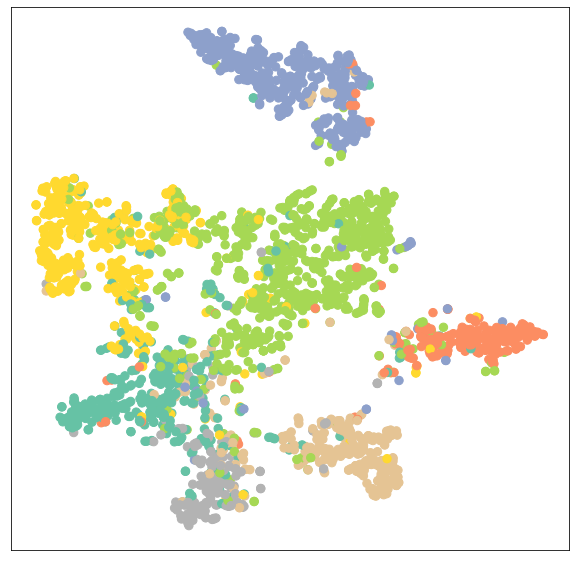

In [93]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# GAT

d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


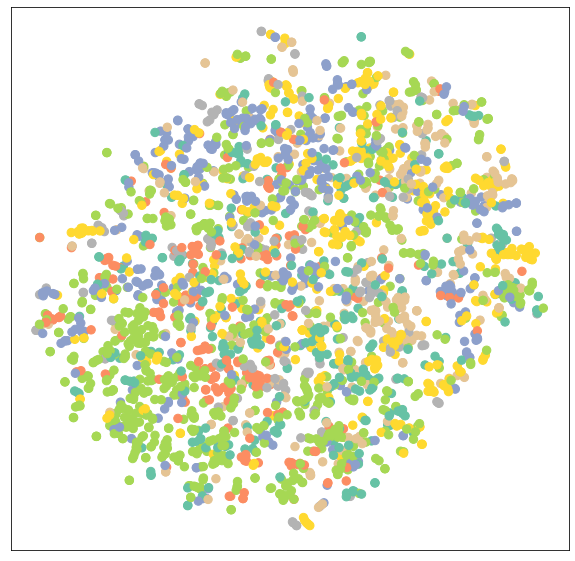

In [94]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(in_c, hid_c)
        self.conv2 = GATConv(hid_c, out_c)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(dataset.num_features, 32, dataset.num_classes)
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [95]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss = torch.nn.CrossEntropyLoss()
model.train()
for epoch in range(0,200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    l = loss(out[data.train_mask], data.y[data.train_mask])
    l.backward()
    optimizer.step()

    print("epoch: {}, loss:{} ".format(epoch+1, l.item()))

epoch: 1, loss:1.9464582204818726 
epoch: 2, loss:1.9376652240753174 
epoch: 3, loss:1.929871916770935 
epoch: 4, loss:1.9163763523101807 
epoch: 5, loss:1.9093120098114014 
epoch: 6, loss:1.896180510520935 
epoch: 7, loss:1.8792351484298706 
epoch: 8, loss:1.8619458675384521 
epoch: 9, loss:1.8423429727554321 
epoch: 10, loss:1.822122573852539 
epoch: 11, loss:1.8077815771102905 
epoch: 12, loss:1.7886412143707275 
epoch: 13, loss:1.7618982791900635 
epoch: 14, loss:1.744349718093872 
epoch: 15, loss:1.7146607637405396 
epoch: 16, loss:1.6963269710540771 
epoch: 17, loss:1.6684354543685913 
epoch: 18, loss:1.640359878540039 
epoch: 19, loss:1.6230210065841675 
epoch: 20, loss:1.595777153968811 
epoch: 21, loss:1.5424517393112183 
epoch: 22, loss:1.5353893041610718 
epoch: 23, loss:1.4850406646728516 
epoch: 24, loss:1.467728614807129 
epoch: 25, loss:1.4360167980194092 
epoch: 26, loss:1.3968579769134521 
epoch: 27, loss:1.3547039031982422 
epoch: 28, loss:1.3066582679748535 
epoch: 2

In [96]:
model.eval()
out = model(data.x, data.edge_index)
preds = out.argmax(dim=1)[data.test_mask]
test_correct = preds==data.y[data.test_mask]
test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

print("test acc:{:.4f}".format(test_acc))

test acc:0.6780


d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


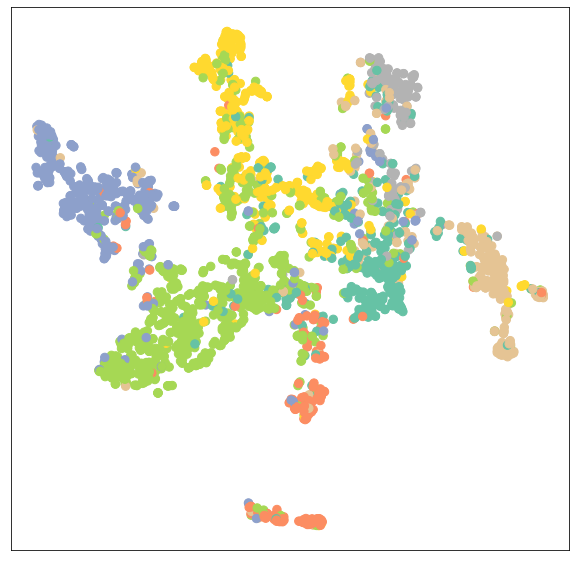

In [97]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# Exercise

## GATV2

d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


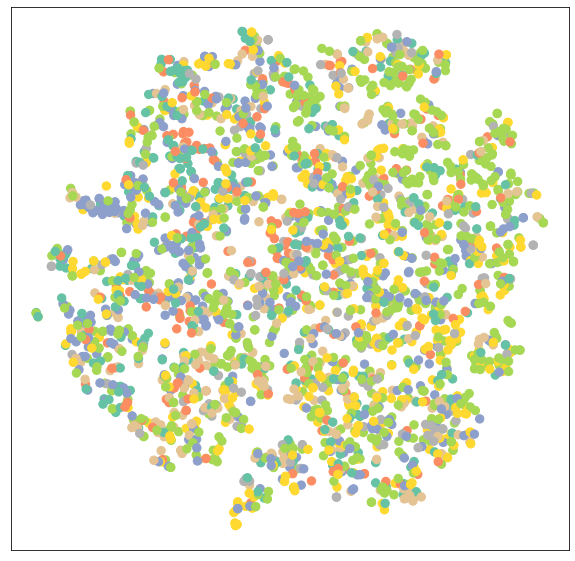

In [98]:
from torch_geometric.nn import GATv2Conv

class GATv2(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super().__init__()
        self.conv1 = GATv2Conv(in_c, hid_c)
        self.conv2 = GATv2Conv(hid_c, out_c)
        self.lin = Linear(out_c, out_c)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x

model = GATv2(dataset.num_features, 32, dataset.num_classes)
model.train()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)
        

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    l = loss(out[data.train_mask], data.y[data.train_mask])
    l.backward()
    optimizer.step()

    print("epoch: {}, loss:{}".format(epoch+1, l.item()))


epoch: 1, loss:1.9603391885757446
epoch: 2, loss:1.9509772062301636
epoch: 3, loss:1.9408937692642212
epoch: 4, loss:1.9364081621170044
epoch: 5, loss:1.9270790815353394
epoch: 6, loss:1.9198461771011353
epoch: 7, loss:1.9168635606765747
epoch: 8, loss:1.9080703258514404
epoch: 9, loss:1.896547555923462
epoch: 10, loss:1.8841023445129395
epoch: 11, loss:1.8758970499038696
epoch: 12, loss:1.864137887954712
epoch: 13, loss:1.8447917699813843
epoch: 14, loss:1.8264509439468384
epoch: 15, loss:1.8153010606765747
epoch: 16, loss:1.7901779413223267
epoch: 17, loss:1.7740600109100342
epoch: 18, loss:1.7513219118118286
epoch: 19, loss:1.7230632305145264
epoch: 20, loss:1.7015349864959717
epoch: 21, loss:1.6586666107177734
epoch: 22, loss:1.640430212020874
epoch: 23, loss:1.6139031648635864
epoch: 24, loss:1.5496104955673218
epoch: 25, loss:1.523019790649414
epoch: 26, loss:1.4823637008666992
epoch: 27, loss:1.4288684129714966
epoch: 28, loss:1.3950791358947754
epoch: 29, loss:1.363208413124084

test acc:0.71


d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


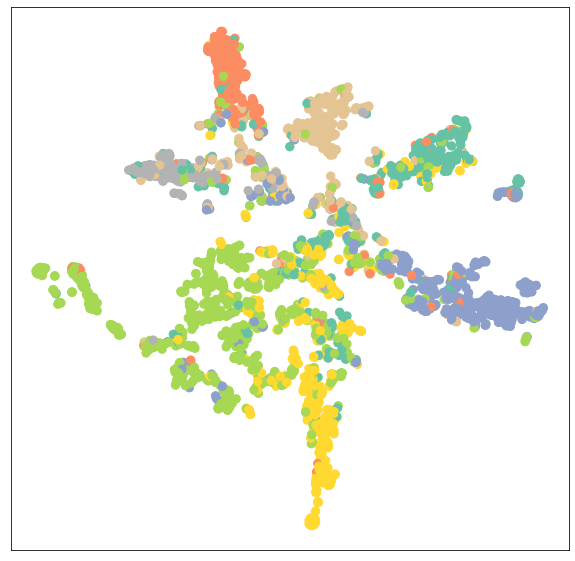

In [100]:
model.eval()

out = model(data.x, data.edge_index)
preds = out.argmax(dim=1)
test_correct = preds[data.test_mask] == data.y[data.test_mask]
test_acc = int(test_correct.sum())/ int(data.test_mask.sum())
print("test acc:{}".format(test_acc))

visualize(out, data.y)

## GraphSage

d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


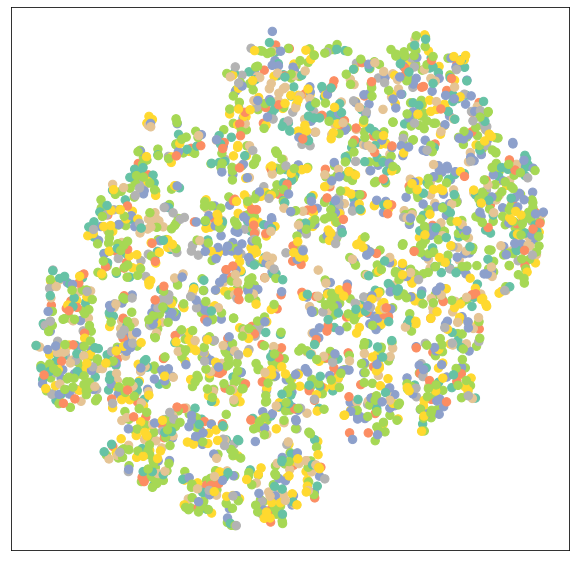

In [101]:
from torch_geometric.nn import SAGEConv

class GraphSage(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super().__init__()
        self.conv1 = SAGEConv(in_c, hid_c)
        self.conv2 = SAGEConv(hid_c, out_c)
        self.lin = Linear(out_c, out_c)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x

model = GraphSage(dataset.num_features, 32, dataset.num_classes)

out = model(data.x, data.edge_index)
visualize(out, data.y)

In [102]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    l = loss(out[data.train_mask], data.y[data.train_mask])
    l.backward()
    optimizer.step()

    print("epoch: {}, loss:{}".format(epoch+1, l.item()))

epoch: 1, loss:1.973165512084961
epoch: 2, loss:1.9604167938232422
epoch: 3, loss:1.9461430311203003
epoch: 4, loss:1.9281744956970215
epoch: 5, loss:1.9041050672531128
epoch: 6, loss:1.8849613666534424
epoch: 7, loss:1.8598116636276245
epoch: 8, loss:1.8295767307281494
epoch: 9, loss:1.7904741764068604
epoch: 10, loss:1.7462339401245117
epoch: 11, loss:1.7208369970321655
epoch: 12, loss:1.6695427894592285
epoch: 13, loss:1.610930323600769
epoch: 14, loss:1.5634099245071411
epoch: 15, loss:1.4946931600570679
epoch: 16, loss:1.4159411191940308
epoch: 17, loss:1.3744642734527588
epoch: 18, loss:1.2923824787139893
epoch: 19, loss:1.2176003456115723
epoch: 20, loss:1.1445753574371338
epoch: 21, loss:1.0696107149124146
epoch: 22, loss:0.9974591135978699
epoch: 23, loss:0.9268195033073425
epoch: 24, loss:0.8669900894165039
epoch: 25, loss:0.7453677654266357
epoch: 26, loss:0.7128254175186157
epoch: 27, loss:0.7074394226074219
epoch: 28, loss:0.6014691591262817
epoch: 29, loss:0.5838423967361

test acc:0.749


d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


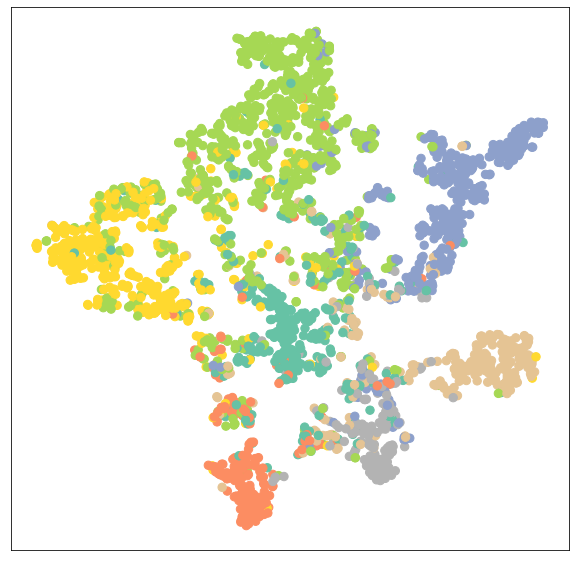

In [103]:
model.eval()

out = model(data.x, data.edge_index)
preds = out.argmax(dim=1)
test_correct = preds[data.test_mask] == data.y[data.test_mask]
test_acc = int(test_correct.sum())/ int(data.test_mask.sum())
print("test acc:{}".format(test_acc))

visualize(out, data.y)